dict_keys(['50per_Ring1.5-5', 'Body', 'Body_Ring0-3', 'BrachialPlexus', 'CTV', 'Esophagus', 'GTV', 'GreatVessels', 'Heart', 'LAD', 'Lung_Cntr', 'Lung_Ipsi', 'Lung_Total', 'PTV', 'PTV_Ring.3-2', 'SpinalCord', 'SpinalCord_05', 'Total Lung-GTV', 'Trachea', 'all_mask', 'img', 'dose', 'dose_scale', 'isVMAT', 'isocenter', 'angle_list', 'origin', 'spacing', 'direction', 'size', 'angle_plate', 'beam_plate'])


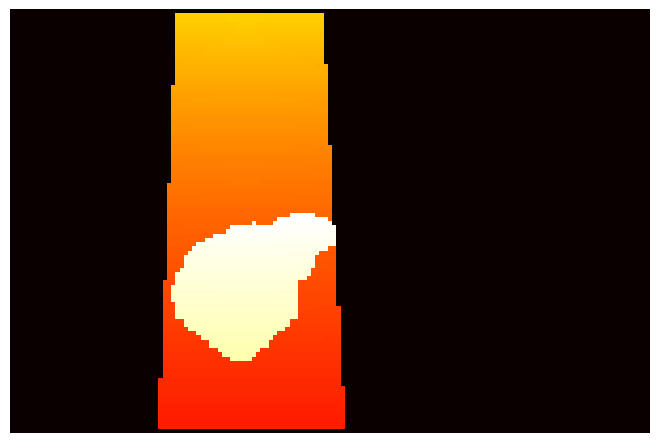

In [1]:
%run generate_geometry.py

In [28]:
from torchvision.transforms.functional import rotate
from torchvision.transforms import InterpolationMode as intpl

In [9]:
img = torch.from_numpy(d.PTV[48]).unsqueeze(0)

In [10]:
img.shape

torch.Size([1, 100, 151])

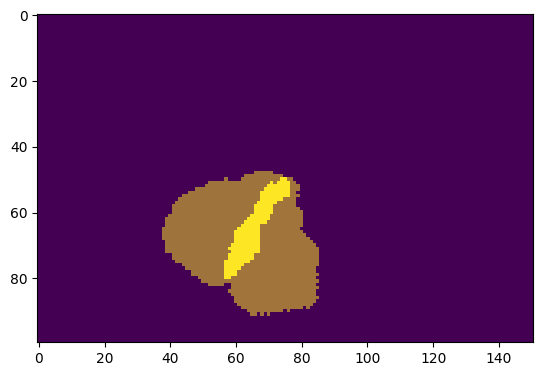

In [16]:
# Default rotation is around the centre
img_r = rotate(img, 45)

plt.imshow(img_r.squeeze())
plt.imshow(img.squeeze(), alpha=0.5)

In [21]:
d.isocenter

[np.float64(48.0), np.float64(64.0), np.float64(55.0)]

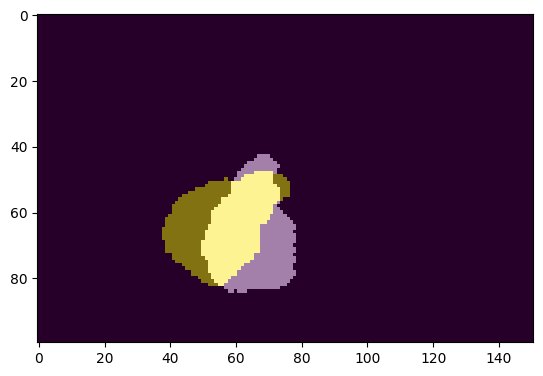

In [ ]:
# Interpolation: InterpolationMode.NEAREST, InterpolationMode.BILINEAR
# default: nearest
img_r = rotate(img, 45, center=(64,55), interpolation=intpl.BILINEAR)

plt.imshow(img_r.squeeze(), cmap='hot')
plt.imshow(img.squeeze(), alpha=0.5)

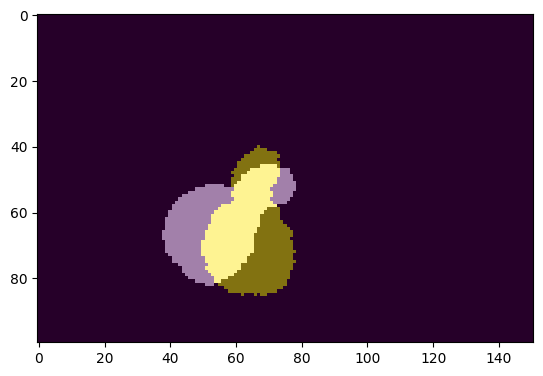

In [33]:
# Multiple slices

ptv = torch.tensor(d.PTV)

ptv_r = rotate(ptv, 45, center=d.isocenter[1:])

plt.imshow(ptv[40], cmap='hot')
plt.imshow(ptv_r[40], alpha=0.5)